### SELF-SUPERVISED DENOISING: PART TWO 
# Random Noise Suppression with Blind-Spot Networks - Field Data Application
#### _Author: Claire Birnie, KAUST_

Authors' websites: 
- https://cebirnie92.github.io/ 

## Tutorial Overview

On completion of this tutorial you will have learnt how to adapt your previously wrote blind-spot denoising procedure to handle noise that has some temporal relationship. In this instance, we imitate this using bandpassed noise. At the end of the tutorial, you will have the opportunity to denoise a field dataset often used for benchmarking random noise suppression procedures.

### Recap
As a reminder, the networks are trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required! This tutorial is the second in the second in our self-supervised denoising series. For a recap on the methodology and the denoising performance under idealistic scenarios, review Tutorial One.

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet import UNet
from tutorial_utils import regular_patching_2D, add_bandlimited_noise, weights_init, set_seed, make_data_loader,plot_corruption, plot_training_metrics, plot_synth_results, plot_field_results



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
cmap='RdBu'
vmin = -0.25
vmax = 0.25

set_seed(42) # For reproducibility set random, numpy and torch seeds

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access.

This is the first dataset as was used in tutorial One therefore we can load it quickly without too much investigation as we already know its size and what it looks like (hence, why no 'TO DOs' this time!).

In [3]:
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5,
                       ):
    """ Function to identify multiple active pixels and replace with values from neighbouring pixels
    
    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    num_activepixels : int
        Number of active pixels to be selected within the patch
    neighbourhood_radius : int
        Radius over which to select neighbouring pixels for active pixel value replacement
    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch 
        mask : numpy 2D array
            Mask showing location of active pixels within the patch 
    """

    n_rad = neighbourhood_radius  # descriptive variable name was a little long

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)
    id_aps = (idx_aps, idy_aps)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP TWO: SELECT NEIGHBOURING PIXEL LOCATIONS
    
    # PART 1: Compute Shift
    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # PART 2: Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft    
    # Ensuring neighbouring pixels within patch window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    # Get x,y of neighbouring pixels
    id_neigh = (idx_neigh, idy_neigh)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP THREE: REPLACE ACTIVE PIXEL VALUES BY NEIGHBOURS
    cp_ptch = patch.copy()
    cp_ptch[id_aps] = patch[id_neigh]
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP FOUR: MAKE ACTIVE PIXEL MASK
    # Make mask and corrupted patch
    mask = np.ones_like(patch)
    mask[id_aps] = 0.

    return cp_ptch, mask


In [4]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
elif torch.backends.mps.is_available(): 
    print("M1 installed! Running on M1!")
    device = torch.device("mps")
else:
    print("No GPU available!")

M1 installed! Running on M1!


In [5]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

/Users/clairebirnie/Documents/Projects/TEACHING/SelfSupervisedDenoising_2024TutorialMaterial/Solutions/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/Users/clairebirnie/Documents/Projects/TEACHING/SelfSupervisedDenoising_2024TutorialMaterial/Solutions/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [6]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    """ Blind-spot network training function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where training will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Training loss across full dataset (i.e., all batches)
        accuracy : float
            Training RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        
        optimizer.zero_grad()
        
        # Predict the denoised image based on current network weights
        yprob = model(X)

        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        # TO DO: Compute loss function only at masked locations and backpropogate it
        # (Hint: only two lines required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        ls.backward()        
        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
            
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

In [7]:
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    """ Blind-spot network evaluation function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Validation loss across full dataset (i.e., all batches)
        accuracy : float
            Validation RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        optimizer.zero_grad()
        
        yprob = model(X)

        with torch.no_grad():            
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
            # TO DO: Compute loss function only at masked locations 
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

***

# PART TWO : APPLYING TO FIELD DATA

(696, 300)


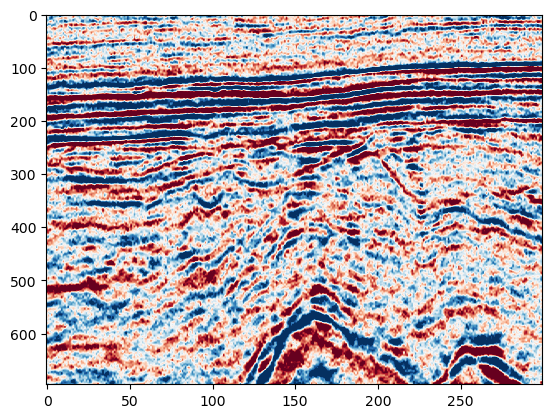

In [8]:
field_data = np.load("../data/FieldExample_RandomNoise.npy")[:696,:300]
print(field_data.shape)
# Plot to see the noise free data
plt.imshow(field_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

#### Patch the data and visualise

As with all our previous examples, this is only a 2D seismic section therefore we need to patch it to generate adequate training samples.

In [9]:
# Regularly extract patches from the noisy data
noisy_patches = regular_patching_2D(field_data, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 7470 patches


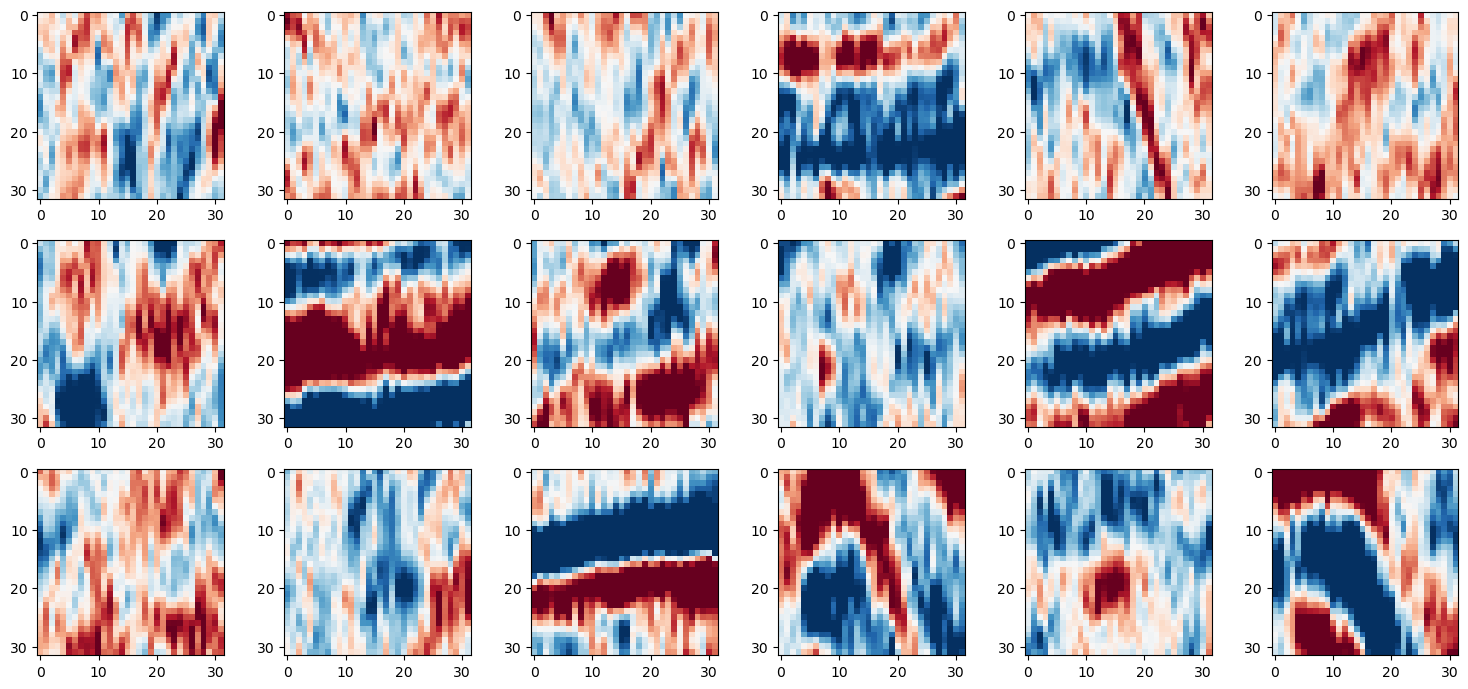

In [10]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE) AND NEIGHBOURHOOD RADIUS

In [11]:
# Choose the percent of active pixels per patch
perc_active = 33
# Choose the neighbourhood_radius to be searched for the neighbouring pixel
neighbourhood_radius = 15


Number of active pixels selected: 
 33.00 percent equals 337 pixels


/var/folders/w_/vsty_ghx2hz7shttlk1lh6t80000gn/T/ipykernel_50218/3185136787.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)


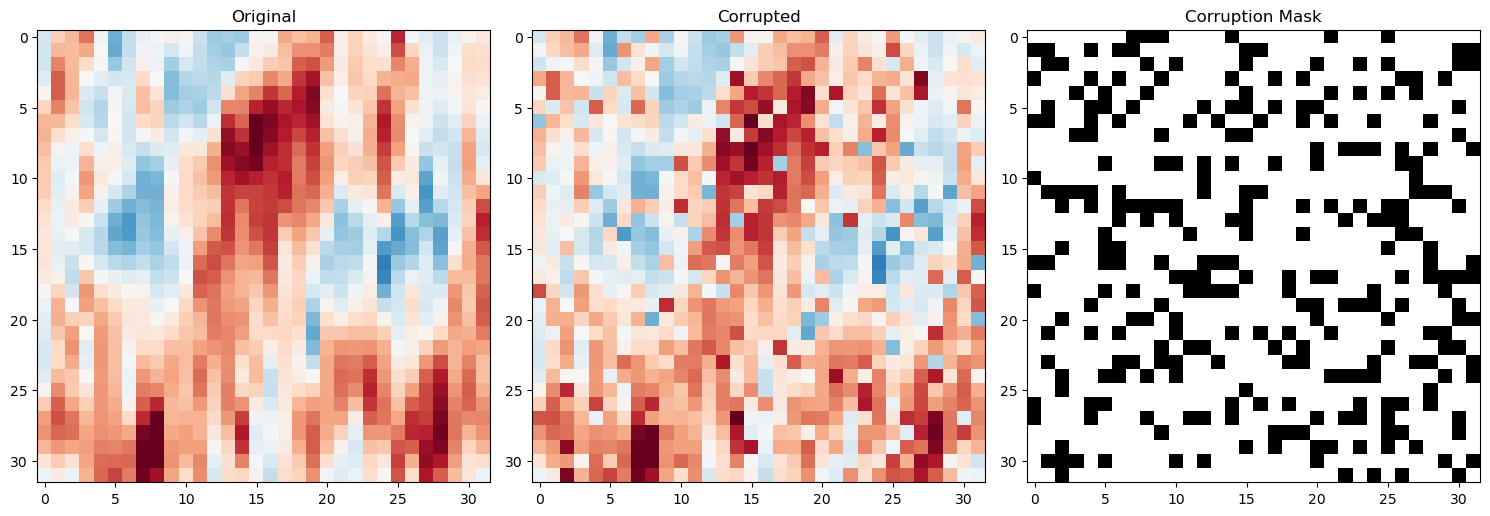

In [12]:
# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))
print("Number of active pixels selected: \n %.2f percent equals %i pixels"%(perc_active,num_activepixels))

# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[5], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=neighbourhood_radius, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = plot_corruption(noisy_patches[5], crpt_patch, mask)

***

## Step Three - Set up network

#### TO DO: MAKE NETWORK FOR FIELD DATA

In [13]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

#### TO DO: SELECT THE NETWORKS TRAINING PARAMETERS

In [14]:
lr = 0.0001  # Learning rate
criterion = nn.L1Loss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step Four - training

As we have the functions already above then we only need to repeat the defining of the training parameters and the training for loop.

#### TO DO: DEFINE TRAINING PARAMETERS


In [15]:
# Choose the number of epochs
n_epochs = 15  

# Choose number of training and validation samples
n_training = 2048
n_test = 256

# Choose the batch size for the networks training
batch_size = 128

In [16]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

In [17]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):        
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=neighbourhood_radius, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = 128,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



/var/folders/w_/vsty_ghx2hz7shttlk1lh6t80000gn/T/ipykernel_50218/3185136787.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.95it/s]


Epoch 0, 
    Training Loss 0.0273,     Training Accuracy 0.1408, 
    Test Loss 0.0195,     Test Accuracy 0.1005 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.16it/s]


Epoch 1, 
    Training Loss 0.0169,     Training Accuracy 0.0858, 
    Test Loss 0.0147,     Test Accuracy 0.0748 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.93it/s]


Epoch 2, 
    Training Loss 0.0146,     Training Accuracy 0.0741, 
    Test Loss 0.0138,     Test Accuracy 0.0693 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.88it/s]


Epoch 3, 
    Training Loss 0.0139,     Training Accuracy 0.0699, 
    Test Loss 0.0132,     Test Accuracy 0.0667 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.27it/s]


Epoch 4, 
    Training Loss 0.0133,     Training Accuracy 0.0673, 
    Test Loss 0.0127,     Test Accuracy 0.0644 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.07it/s]


Epoch 5, 
    Training Loss 0.0129,     Training Accuracy 0.0655, 
    Test Loss 0.0125,     Test Accuracy 0.0634 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.97it/s]


Epoch 6, 
    Training Loss 0.0128,     Training Accuracy 0.0648, 
    Test Loss 0.0124,     Test Accuracy 0.0630 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.94it/s]


Epoch 7, 
    Training Loss 0.0125,     Training Accuracy 0.0640, 
    Test Loss 0.0122,     Test Accuracy 0.0619 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.34it/s]


Epoch 8, 
    Training Loss 0.0125,     Training Accuracy 0.0635, 
    Test Loss 0.0121,     Test Accuracy 0.0617 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.67it/s]


Epoch 9, 
    Training Loss 0.0123,     Training Accuracy 0.0628, 
    Test Loss 0.0119,     Test Accuracy 0.0610 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.13it/s]


Epoch 10, 
    Training Loss 0.0123,     Training Accuracy 0.0623, 
    Test Loss 0.0118,     Test Accuracy 0.0603 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.66it/s]


Epoch 11, 
    Training Loss 0.0121,     Training Accuracy 0.0615, 
    Test Loss 0.0118,     Test Accuracy 0.0595 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.06it/s]


Epoch 12, 
    Training Loss 0.0120,     Training Accuracy 0.0610, 
    Test Loss 0.0120,     Test Accuracy 0.0606 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.44it/s]


Epoch 13, 
    Training Loss 0.0121,     Training Accuracy 0.0608, 
    Test Loss 0.0117,     Test Accuracy 0.0592 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.13it/s]

Epoch 14, 
    Training Loss 0.0119,     Training Accuracy 0.0601, 
    Test Loss 0.0116,     Test Accuracy 0.0587 


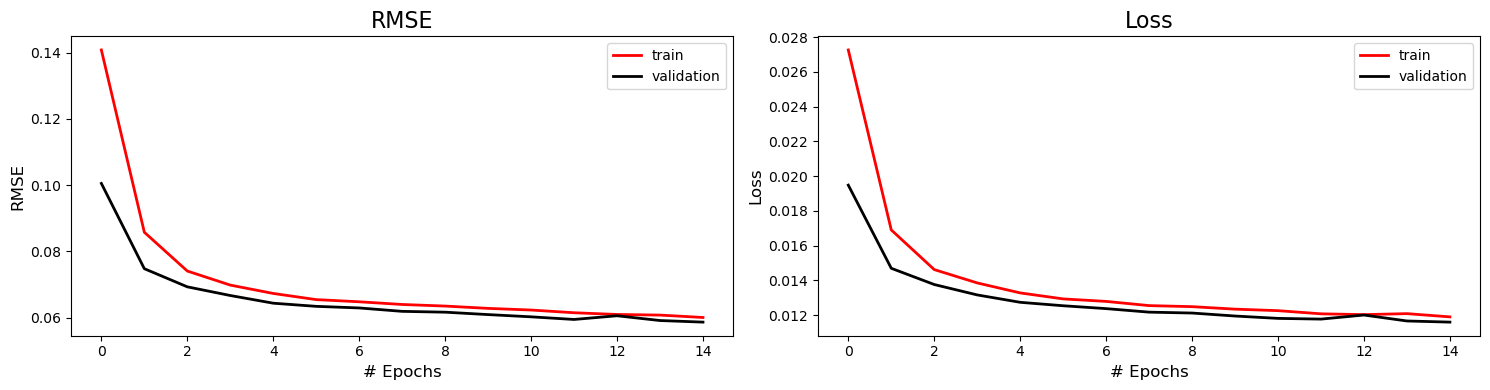

In [18]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

#### TO DO: APPLY THE NETWORK TO THE ORIGINAL NOISY DATA

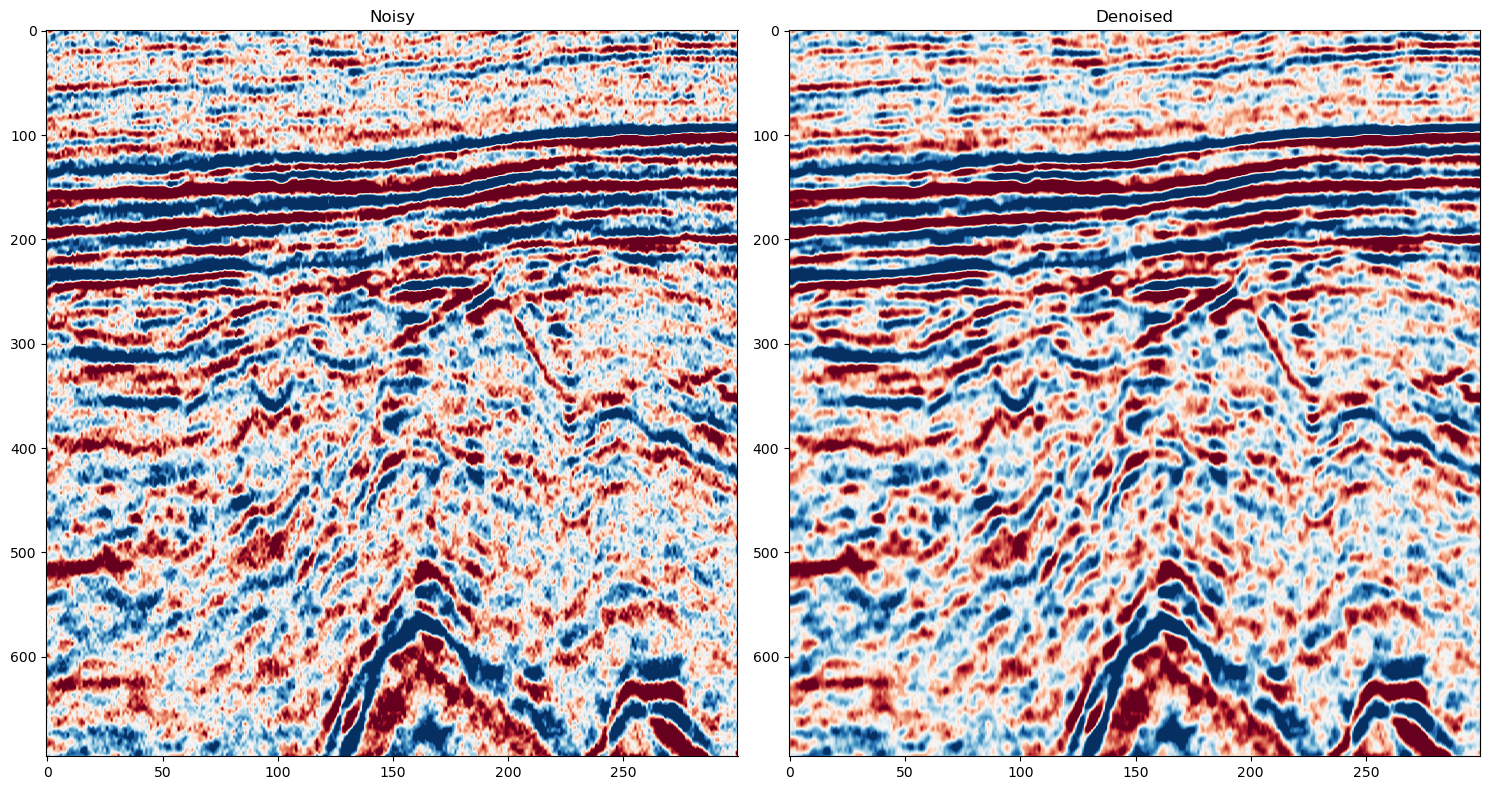

In [19]:
# Convert field dataset to tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(field_data,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig, axs = plot_field_results(field_data, test_pred)